In [1]:
import os
import random
import math
import networkx as nx
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle

with open("training_dataset_SiouxFalls_congestion.pkl", "rb") as f:
    training_dataset = pickle.load(f)

num_samples = 3000
attack_ratio = 0.4  # 원하는 값으로 조정
bound_threshold = 0.2
random.seed(1234)

In [2]:
# 1. Hyperparams & Dataset Info
# ----------------------------------------
# 예시 가정: training_dataset = list of dict(...)
#           각 rec: { 'shortest_travel_time':..., 'manipulated_travel_time':..., 'alternative_paths': [ (id, time), ... ] }
# 아래와 같이 필요한 변수도 정의해두세요
num_alts = max(len(rec['alternative_paths']) for rec in training_dataset)
input_dim = 2 + num_alts  # [T_star, T_manip] + num_alts
k = 1 + num_alts          # 출력 차원

# ----------------------------------------
# 2. Model definitions (기존과 동일)
# ----------------------------------------
class Generator(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, k)  # (k-dim logits)

    def forward(self, x):
        # 배치크기가 1일 때 BatchNorm 문제 방지
        if x.size(0) == 1:
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            h = F.relu(self.fc3(h))
        else:
            h = F.relu(self.bn1(self.fc1(x)))
            h = F.relu(self.bn2(self.fc2(h)))
            h = F.relu(self.bn3(self.fc3(h)))
        return self.fc4(h)

class Discriminator(nn.Module):
    """
    전통적 Critic (WGAN 용)
    입력: (B,2) => [delta, diff_fake]
    출력: (B,1) => real/fake 구별 점수
    """
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        if x.size(0) == 1:
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
        else:
            h = F.relu(self.bn1(self.fc1(x)))
            h = F.relu(self.bn2(self.fc2(h)))
        return self.fc3(h)

# --------------------------------------------------------
# 3. Instantiate Models & Optimizers
# --------------------------------------------------------
generator      = Generator(hidden_dim=128)
discriminator  = Discriminator(hidden_dim=128)

# delay를 조절하는 람다(학습 X, 직접 설정)
lambda_delay = 1  

opt_G = optim.Adam(generator.parameters(), lr=5e-5, betas=(0.5, 0.9))
opt_D = optim.Adam(discriminator.parameters(), lr=5e-5, betas=(0.5, 0.9))

# --------------------------------------------------------
# 4. WGAN Loss Functions (Vanilla + delay)
# --------------------------------------------------------
def wgan_critic_loss(real, fake):
    """
    WGAN Critic Loss:  -E[D(real)] + E[D(fake)]
    """
    return -real.mean() + fake.mean()

def wgan_generator_loss(
    critic_fake, 
    gen_input, delta,
    lambda_delay
):
    """
    Generator Loss = 
      (i) Adversarial: -E[D(fake)]
      (ii) Delay:      + lambda_delay * ReLU(delta.mean())
    """
    # Adversarial
    loss_adv = -critic_fake.mean()

    # Delay: manipulated_time = T_star + delta
    # delta = manipulated_time - T_star
    # delta.mean()가 음수가 되면 의미가 없으니, ReLU로 양수만 반영
    delay_loss = F.relu(delta).mean()

    return loss_adv + lambda_delay * delay_loss

# --------------------------------------------------------
# 5. Training Loop
# --------------------------------------------------------
weight_clip = 0.01
patience    = 20
best_loss_G = float('inf')
early_stop  = 0
num_epochs  = 5000
batch_size  = 100

# 로그 기록용
D_real_history = []
D_fake_history = []
G_loss_history = []

for epoch in range(1, num_epochs+1):
    random.shuffle(training_dataset)
    epoch_D = 0.0
    epoch_G = 0.0
    delta_vals = []

    # 배치 학습
    for i in range(0, len(training_dataset), batch_size):
        batch = training_dataset[i:i+batch_size]
        if not batch:
            break

        # ----------------------------------
        # (1) Prepare batch data
        # ----------------------------------
        gen_in = []
        T_alt_eff_list = []

        for rec in batch:
            T_star  = rec['shortest_travel_time']
            T_manip = rec['manipulated_travel_time']
            alts    = [t for (_, t) in rec['alternative_paths']]
            # alt 효용(?)은 여기서 사실 안 써도 되나, 
            # 기존 Trad Critic 형식 그대로 두겠다면 pseudo real/fake 계산용으로 남김
            wts     = [math.exp(-1.0*(t - T_star)) for t in alts]
            wsum    = sum(wts) if sum(wts)!=0 else 1e-8
            T_alt_eff = sum(w*t for w,t in zip(wts, alts)) / wsum

            # 패딩
            padded_alts = alts + [1e6]*(num_alts - len(alts))
            gen_in.append([T_star, T_manip] + padded_alts)
            T_alt_eff_list.append(T_alt_eff)

        gen_input = torch.tensor(gen_in, dtype=torch.float32)  # (B, input_dim)
        
        # ----------------------------------
        # (2) Generator forward
        # ----------------------------------
        logits = generator(gen_input)             # (B, k)
        probs  = F.softmax(logits, dim=1)         # (B, k)

        # 혼합 통행시간
        # path_times = [T_manip] + padded_alts
        # manipulated_mix = Σ (probs_i * path_times_i)
        path_times      = torch.cat([gen_input[:,1:2], gen_input[:,2:2+num_alts]], dim=1)
        manipulated_mix = (probs * path_times).sum(dim=1, keepdim=True)
        delta           = manipulated_mix - gen_input[:,0:1]   # (B,1)

        # ----------------------------------
        # (3) Critic input (real vs fake)
        # ----------------------------------
        # (a) real -> [0, T_alt_eff - T_star]
        T_alt_eff_arr = torch.tensor(T_alt_eff_list, dtype=torch.float32).unsqueeze(1)
        diff_real = (T_alt_eff_arr - gen_input[:,0:1]).detach()

        # (b) fake -> [delta, T_alt_eff - manipulated_mix]
        diff_fake = (T_alt_eff_arr - manipulated_mix)

        real_input = torch.cat([torch.zeros_like(delta), diff_real.detach()], dim=1) # (B,2)
        fake_input = torch.cat([delta.detach(),         diff_fake.detach()], dim=1) # (B,2)

        # ----------------------------------
        # (4) Discriminator Update
        # ----------------------------------
        out_real = discriminator(real_input)  # (B,1)
        out_fake = discriminator(fake_input)  # (B,1)
        loss_D = wgan_critic_loss(out_real, out_fake)

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # WGAN weight clipping
        for p in discriminator.parameters():
            p.data.clamp_(-weight_clip, weight_clip)

        # ----------------------------------
        # (5) Generator Update
        # ----------------------------------
        critic_fake = discriminator(torch.cat([delta, diff_fake], dim=1))
        loss_Gen = wgan_generator_loss(
            critic_fake, gen_input, delta,
            lambda_delay
        )

        opt_G.zero_grad()
        loss_Gen.backward()
        opt_G.step()

        # ----------------------------------
        # (6) Logging
        # ----------------------------------
        epoch_D += loss_D.item()
        epoch_G += loss_Gen.item()
        delta_vals += delta.detach().cpu().flatten().tolist()

    # -- End of epoch --
    n_batches = max(1, len(training_dataset)//batch_size)
    epoch_D_mean = epoch_D / n_batches
    epoch_G_mean = epoch_G / n_batches
    avg_delta    = np.mean(delta_vals) if len(delta_vals) > 0 else 0.0

    # Critic 모니터링 (배치 평균)
    D_real_mean = out_real.mean().item()
    D_fake_mean = out_fake.mean().item()
    WD_est      = D_real_mean - D_fake_mean

    print(f"[{epoch}/{num_epochs}] "
          f"D={epoch_D_mean:.4f} | G={epoch_G_mean:.4f} | Δavg={avg_delta:.4f} | WD≈{WD_est:.4f}")

    D_real_history.append(D_real_mean)
    D_fake_history.append(D_fake_mean)
    G_loss_history.append(epoch_G_mean)

    # Early stopping
    if epoch_G_mean < best_loss_G:
        best_loss_G = epoch_G_mean
        early_stop  = 0
        best_state  = generator.state_dict()
    else:
        early_stop += 1
        if early_stop >= patience:
            print("Early stopping.")
            break

# 최종 Generator 로드
generator.load_state_dict(best_state)
print("Vanilla WGAN Training (Max Delay) complete.")

[1/5000] D=-0.0027 | G=678111.7750 | Δavg=678111.7824 | WD≈0.0002
[2/5000] D=-0.0003 | G=663856.3063 | Δavg=663856.3078 | WD≈0.0003
[3/5000] D=-0.0004 | G=649084.7188 | Δavg=649084.7393 | WD≈0.0004
[4/5000] D=-0.0005 | G=632010.7000 | Δavg=632010.7047 | WD≈0.0005
[5/5000] D=-0.0006 | G=615664.8438 | Δavg=615664.8375 | WD≈0.0007
[6/5000] D=-0.0007 | G=600358.7188 | Δavg=600358.7157 | WD≈0.0008
[7/5000] D=-0.0009 | G=581568.8313 | Δavg=581568.8350 | WD≈0.0009
[8/5000] D=-0.0010 | G=565128.2625 | Δavg=565128.2551 | WD≈0.0011
[9/5000] D=-0.0012 | G=545475.1687 | Δavg=545475.1743 | WD≈0.0014
[10/5000] D=-0.0014 | G=529103.8969 | Δavg=529103.8927 | WD≈0.0015
[11/5000] D=-0.0017 | G=511058.4750 | Δavg=511058.4754 | WD≈0.0018
[12/5000] D=-0.0019 | G=494990.2062 | Δavg=494990.2054 | WD≈0.0020
[13/5000] D=-0.0021 | G=479868.4375 | Δavg=479868.4231 | WD≈0.0022
[14/5000] D=-0.0023 | G=459149.2125 | Δavg=459149.2215 | WD≈0.0024
[15/5000] D=-0.0025 | G=445019.6312 | Δavg=445019.6146 | WD≈0.0026
[16/

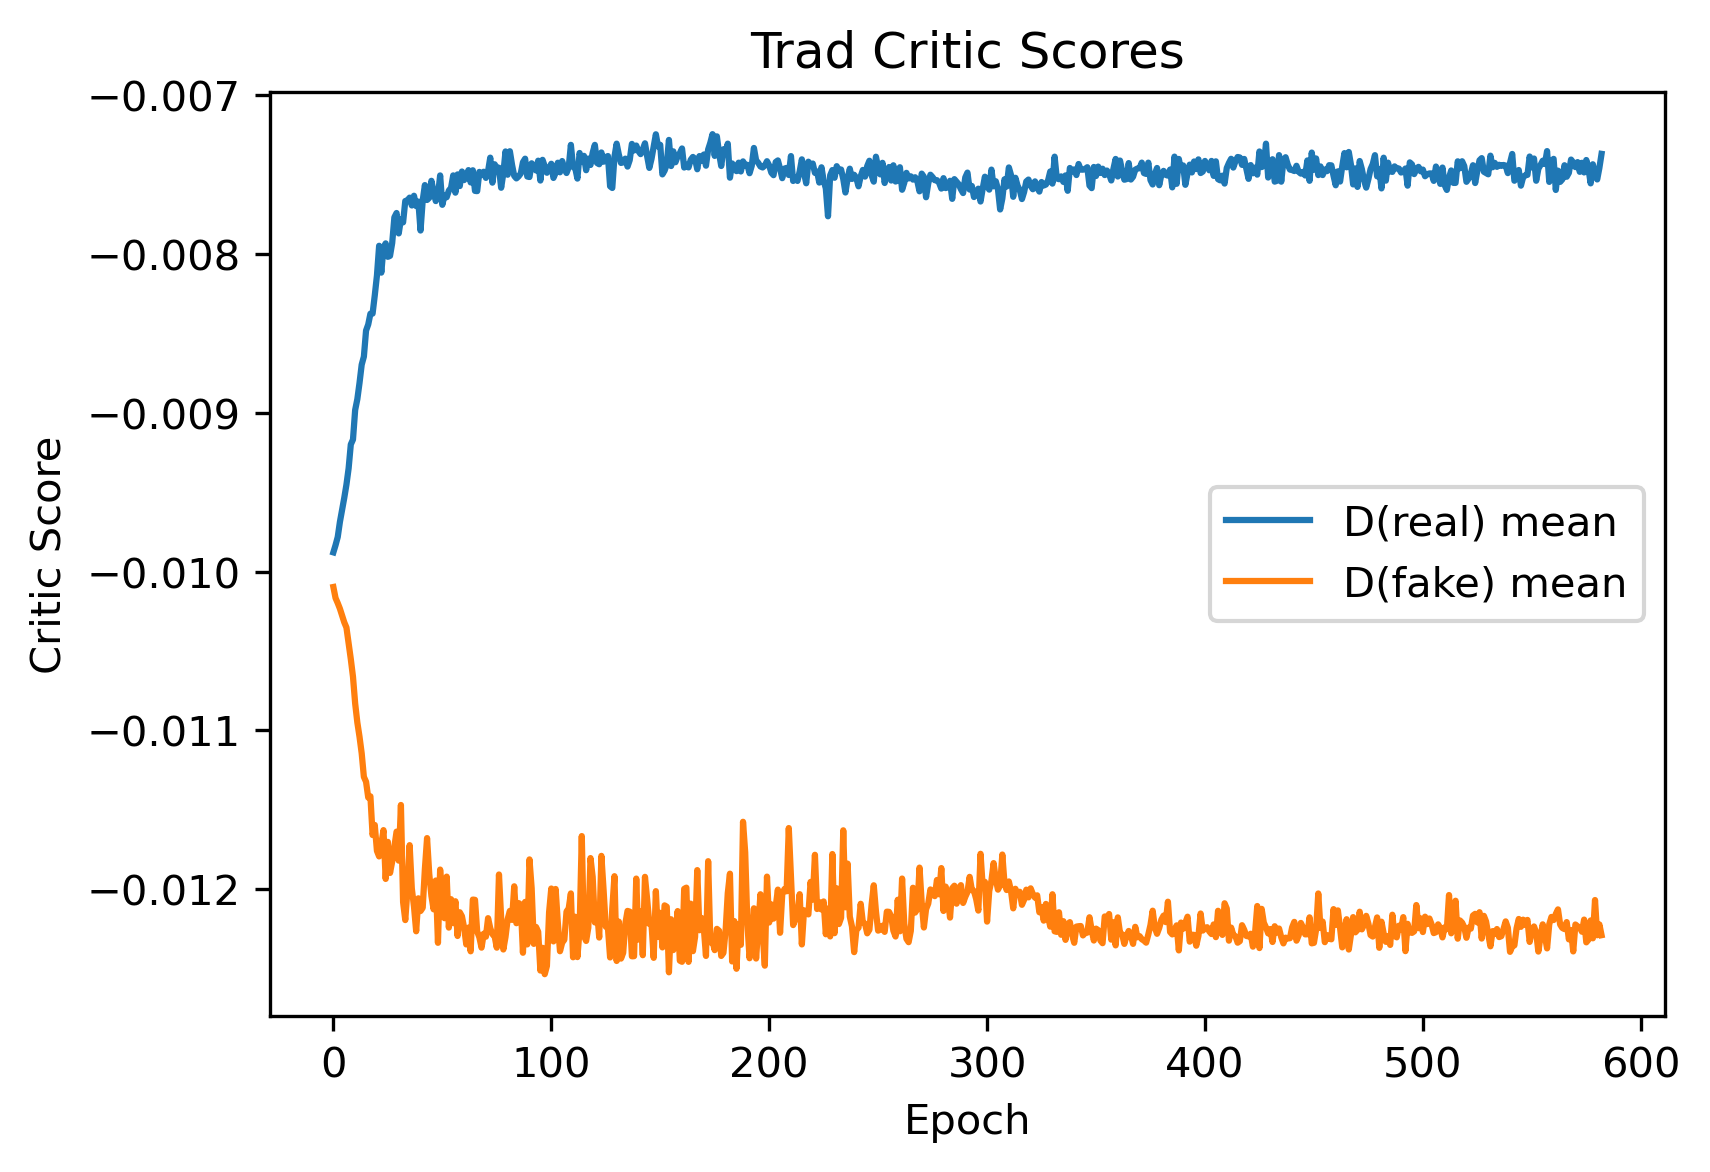

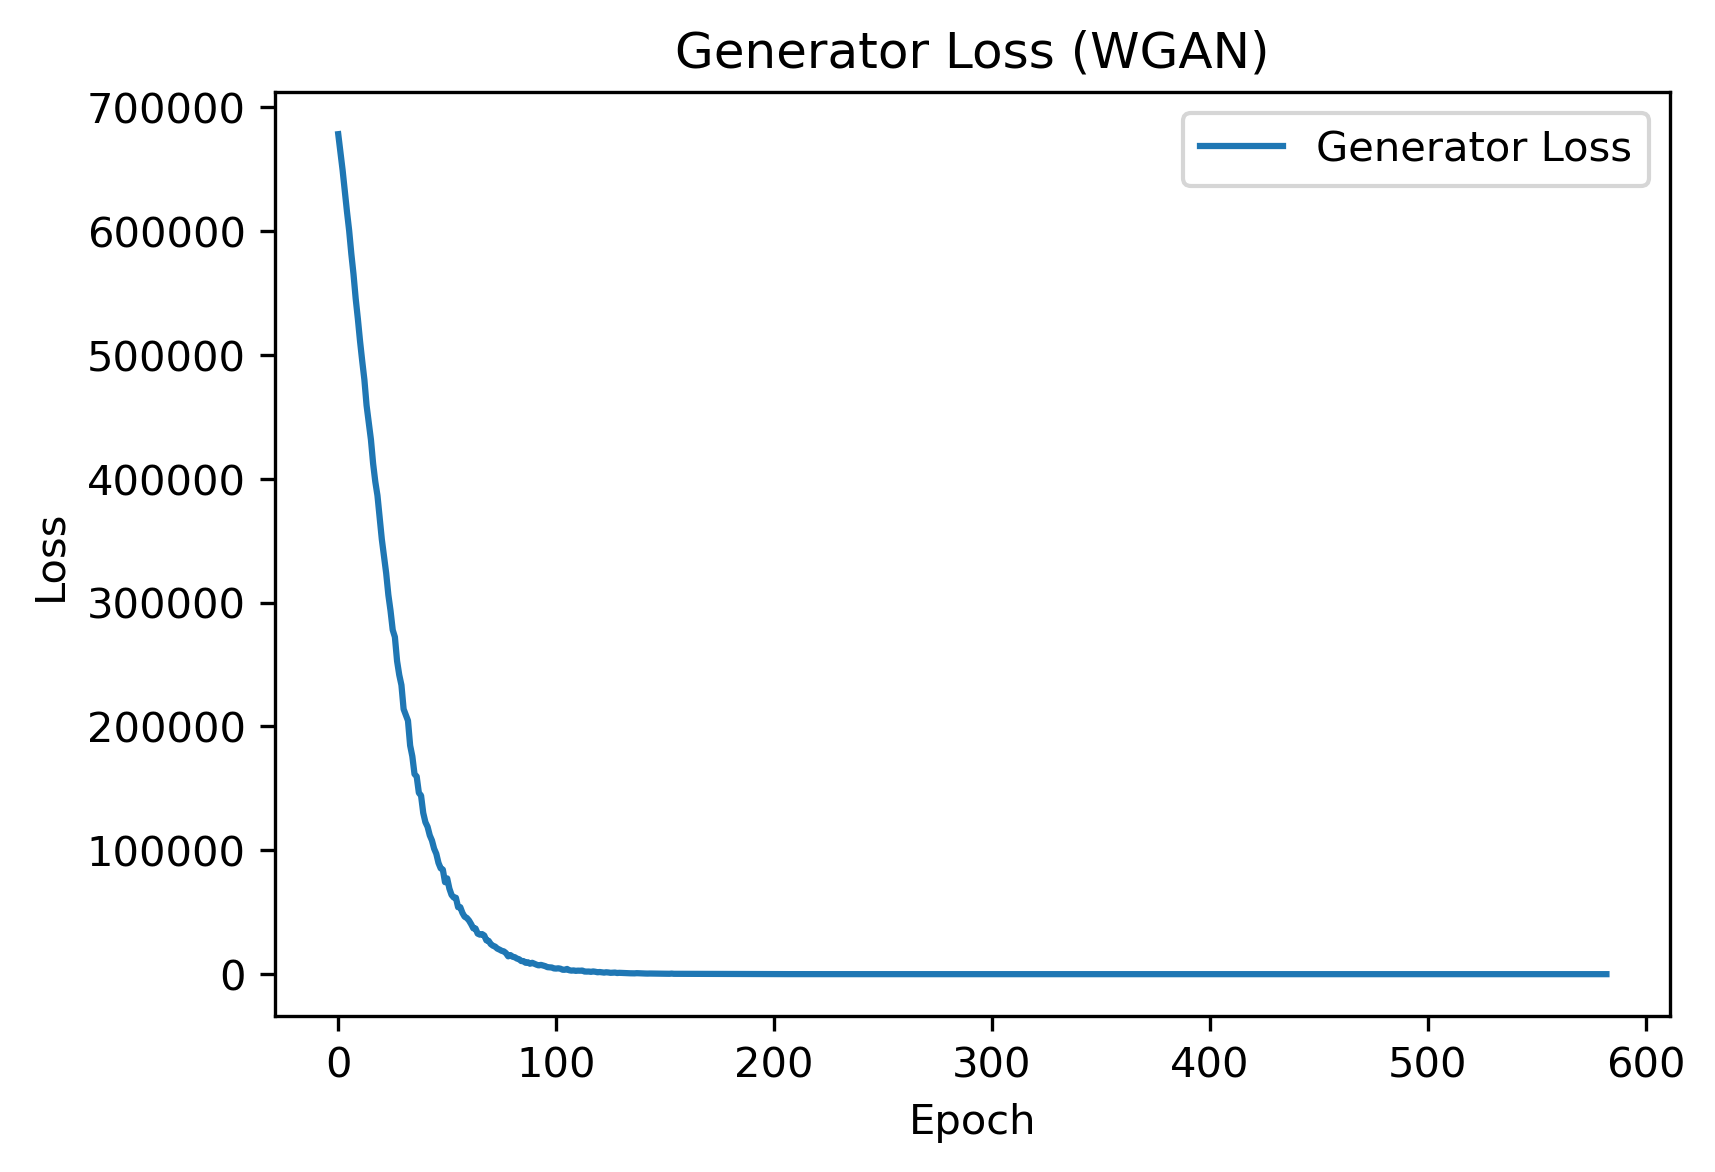

In [3]:
def plot_critic_scores(D_real_hist, D_fake_hist, title="Critic Output", file_name=None):
    plt.figure(figsize=(6,4), dpi=300)  # dpi=300으로 설정
    plt.plot(D_real_hist, label="D(real) mean")
    plt.plot(D_fake_hist, label="D(fake) mean")
    plt.xlabel("Epoch")
    plt.ylabel("Critic Score")
    plt.title(title)
    plt.legend()
    # 파일 이름이 주어지면 저장
    if file_name is not None:
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
    # plt.show()를 쓰면 화면에 표시되며, 필요 없다면 주석 처리 가능
    plt.show()
    plt.close()

def plot_G_loss(G_loss_hist, title="Generator Loss (WGAN)", file_name=None):
    plt.figure(figsize=(6,4), dpi=300)
    plt.plot(G_loss_hist, label="Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    if file_name is not None:
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# 사용 예시:
plot_critic_scores(D_real_history, D_fake_history,
                   title="Trad Critic Scores",
                   file_name="WGAN_SiouxFalls_congestion_trad_critic_scores.png")

plot_G_loss(G_loss_history,
            title="Generator Loss (WGAN)",
            file_name="WGAN_SiouxFalls_congestion_generator_loss.png")

In [8]:
num_alts = max(len(rec['alternative_paths']) for rec in training_dataset)

###############################
# 7. 시뮬레이션 함수 수정
#    (조작경로 = 실제 시간도 T_star)
###############################
def simulate_bounded(rec, mT):
    """
    기존 로직 + '조작경로 선택 시 실제 소요시간 = T_star'
    """
    alts = [t for _, t in rec['alternative_paths']]
    for t in alts:
        if abs(t - mT) <= bound_threshold * mT:
            return 0, rec['shortest_travel_time']  # 조작경로 선택 → 실제 T_star
    if not alts:
        # 대안이 전혀 없으면 → 조작경로 선택, 실제 T_star
        return 0, rec['shortest_travel_time']
    # 대안을 선택하면 그 중 최솟값
    rel = int(np.argmin(alts))
    return rel+1, alts[rel]

def simulate_perfect(rec, mT):
    """
    완전 합리적이나, 조작경로 선택 시 실제로도 T_star 소요.
    """
    alt_times = [t for _, t in rec['alternative_paths']]
    # times[0] = 조작경로(안내는 mT, 실제론 T_star)
    # times[1:] = alt_times
    times = [mT] + alt_times
    idx = int(np.argmin(times))

    if idx == 0:
        # 조작경로 선택 → 실제 시간 T_star
        return 0, rec['shortest_travel_time']
    else:
        # 대안 중 하나
        chosen_time = alt_times[idx - 1]
        return idx, chosen_time

################################
# 8. metrics 계산용 함수
################################
def compute_metrics(dataset, manip_list, sim_func):
    chosen_times = []
    delays       = []
    succ         = []
    time_incs    = []

    for rec, mT in zip(dataset, manip_list):
        idx, t_chosen = sim_func(rec, mT)
        T_star = rec['shortest_travel_time']

        chosen_times.append(t_chosen)
        # 기존 최단시간 대비 증가
        delay  = max(0.0, t_chosen - T_star)
        delays.append(delay)

        # 예: idx!=0 이면 "조작경로 아닌 대안 선택"을 success로 볼 수도 있고,
        #     "idx==0이면 조작경로(실제 t_chosen=T_star)"이므로 fail이라 볼 수도 있음.
        succ.append(int(idx != 0))

        # 퍼센트 증가율
        if T_star > 0:
            inc = 100.0 * (t_chosen - T_star) / T_star
        else:
            inc = 0.0
        time_incs.append(inc)

    chosen_arr = np.array(chosen_times)
    delays_arr = np.array(delays)
    succ_arr   = np.array(succ)
    inc_arr    = np.array(time_incs)

    return {
        "Average Time":      chosen_arr.mean(),
        "Time Std":          chosen_arr.std(ddof=0),
        "ADT (min)":     delays_arr.mean(),
        "SDDT (min)":         delays_arr.std(ddof=0),
        "TDT (min)":       delays_arr.sum(),
        "APDT (%)": inc_arr.mean(),
        "SR (%)":  succ_arr.mean()*100
    }

################################
# 9. 예시: Naive / Random / WGAN으로 조작
################################
#  - "조작된 통행시간" 리스트 생성
#  - simulate_* 로 성능평가
################################
generator.eval()

naive_list  = []
random_list = []
gan_list    = []

for rec in training_dataset:
    T_star = rec['shortest_travel_time']
    # (A) Naive: target = T_star*(1+attack_ratio)
    candidates = [T_star] + [t for _, t in rec['alternative_paths']]
    target     = T_star * (1 + attack_ratio)
    diffs      = [abs(c - target) for c in candidates]
    idx_naive  = int(np.argmin(diffs))
    naive_list.append(candidates[idx_naive])

    # (B) Random
    random_list.append(random.choice(candidates))

    # (C) WGAN (GAN) => 혼합된 통행시간
    alts   = [t for _, t in rec['alternative_paths']]
    padded = alts + [1e4]*(num_alts - len(alts))

    inp    = torch.tensor([[T_star, rec['manipulated_travel_time']] + padded],
                          dtype=torch.float32)
    with torch.no_grad():
        logits = generator(inp)  # (1,k)
        probs  = F.softmax(logits, dim=1).numpy()[0]
    path_times = np.array([rec['manipulated_travel_time']] + padded)
    manipulated_mix = (probs * path_times).sum()
    gan_list.append(float(manipulated_mix))

rows = []
for name, lst in [("Naive", naive_list), ("Random", random_list), ("WGAN", gan_list)]:
    # Bounded
    mb = compute_metrics(training_dataset, lst, simulate_bounded)
    mb.update({"Method": name, "Response Model": "Bounded"})
    rows.append(mb)

    # Perfect
    mp = compute_metrics(training_dataset, lst, simulate_perfect)
    mp.update({"Method": name, "Response Model": "Perfect"})
    rows.append(mp)

df = pd.DataFrame(rows)[[
    "Response Model","Method",
    "Average Time","Time Std",
    "ADT (min)","SDDT (min)",
    "TDT (min)","APDT (%)",
    "SR (%)"
]]
print(df.to_string(index=False))

Response Model Method  Average Time  Time Std  ADT (min)  SDDT (min)   TDT (min)  APDT (%)  SR (%)
       Bounded  Naive     24.780637  9.249009   0.348990    2.451996  348.990007  1.835251     2.1
       Perfect  Naive     25.533204  9.781138   1.101558    2.182234 1101.557755  4.146830    60.4
       Bounded Random     25.331553  8.774903   0.899907    2.771074  899.906552  5.843583    11.6
       Perfect Random     26.519916  9.888307   2.088269    3.731791 2088.269027  8.976399    62.1
       Bounded   WGAN     25.172278  9.281547   0.740631    3.259109  740.631148  3.951631    14.3
       Perfect   WGAN     25.992245  9.438788   1.560598    2.467516 1560.598127  6.916303    71.9


In [9]:
# ① 저장 폴더 생성
save_dir = "./Results_SiouxFalls"
os.makedirs(save_dir, exist_ok=True)

# ② 최적 Generator/Discriminator 파라미터 저장
gen_path = os.path.join(save_dir, "WGAN_Congestion_generator_best.pth")
disc_path = os.path.join(save_dir, "WGAN_Congestion_discriminator_best.pth")
torch.save(generator.state_dict(), gen_path)
torch.save(discriminator.state_dict(), disc_path)
print(f"Saved generator weights to {gen_path}")
print(f"Saved discriminator weights to {disc_path}")

# ③ 학습 로그(history) 저장 (pickle)
history_path = os.path.join(save_dir, "WGAN_Congestion_training_history.pkl")
with open(history_path, "wb") as f:
    pickle.dump({
        "D_real_history": D_real_history,
        "D_fake_history": D_fake_history,
        "G_loss_history": G_loss_history
    }, f)
print(f"Saved training history to {history_path}")

# ④ 결과 DataFrame(df) CSV로 저장
results_path = os.path.join(save_dir, "WGAN_Congestion_results_summary.csv")
df.to_csv(results_path, index=False)
print(f"Saved results summary to {results_path}")

Saved generator weights to ./Results_SiouxFalls\WGAN_Congestion_generator_best.pth
Saved discriminator weights to ./Results_SiouxFalls\WGAN_Congestion_discriminator_best.pth
Saved training history to ./Results_SiouxFalls\WGAN_Congestion_training_history.pkl
Saved results summary to ./Results_SiouxFalls\WGAN_Congestion_results_summary.csv
